---
MINGAR Smartwear Data Analysis

The effect of age and skin tone on product choice and sleep trackings

Author: "Report prepared for MINGAR by Visionaries"

---

In [1]:

library(tidyverse)
library(lme4)
library(rvest)
library(polite)
library(lmtest)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Background and Aim
The technology company MINGAR is interested in understanding their customers better and determining whether there are issues with their products. In particular, there are two research questions we were interested in: first, what are the characteristics of the newer and affordable product consumers and how do they differ from traditional consumers? The goal with this question is to understand if the more affordable device is being bought by people with lower income levels. We used a Binomial general linear model to estimate whether a customer bought a device from the new line. Second, individuals with darker skin experience more issues with sleep tracking in their device than people with lighter skin? There have been complaints about this, and we want to resolve any issues if they exist. We fit a Poisson general linear model to estimate the number of sleep quality flags per hour.

## Key Findings
•	Individuals with the darkest skin tone had an average of 11.8 flags per hour, while those with the lightest skin tone had an average of 1.2 flags per hour. \
•	Individuals with the darkest skin tone were 95 percent likely to be flagged between 10.6 to 11.3 times more than individuals with the lightest skin tone. \
•	The type of device had no significant effect on number of flags, so this issue persists across all devices \
• A customer is likely to purchase the newer product are 2.1316 times higher when the customer is age 92 compared to a customer aged 18, with a 95% confidence interval of (1.28, 1.66). \
• There was no significant effect on the odds of a consumer buying the new product when their income of area corresponding to their postal code is maximum compared to the minimum income of the consumer. 

## Limitations
There are several limitations to this study. First, after removing missing observations, the sample size decreased from 974 to 710. Second, there may be some missing variables that affect sleep quality, such as health issues, stress levels, or sleep times. Also, we do not have the actual data of the customer's skin colour because the emoji colour may not match a customer's real skin tone and the data contained a big portion of customers who had not set on any colour for their emojis. Thirdly, there may have been useful analysis in which pronouns rather than biological sex could have affected the odds of a customer buying the newer product and their sleep quality flags. Furthermore, for the technical resources we used the Wald method to calculate our confidence intervals. Even though Wald method is known to be fast and efficient it may not be as precise as the profile likelihood.

## Question 1: What are the characteristics of the newer and affordable product consumers and how do they differ from traditional consumers?

### Data cleaning

Four sets of data files were provided by the client for thew purposes of our research questions. 
1. cust_dev: matching each customer id to their current device 
2. customer: general information about each of the customer for use in the app and associated profile and chat features 
3. device: additional information about each device 
4. cust_sleep: the customer sleep data 

Furthermore, we webscraped the device data from fitness tracker info hub website which contains device name, line, recommended retail price, battery life etc. Also, to estimate the customer household median income the canadian census API was used. The postal code of the customer was matched to the list of census regions to get the median income in that area. Since postal codes can be linked to multiple census subdivisions, the mean of the median incomes from those CSDuid was determined for each customer. 

For the first reasearch question we merged the data files and chose the following variables for our data analysis: 
1. new_line: binary variable which indicates 1 if the product is in the active/advance line, 0 if the product is in the traditional line 
2. skin_colour: skin tone modifier for emojis when using the chat and react features of the social component of the client app. 5 skin colours were present ranging from Light to Dark, additionally if the customer had no set skin tone the NA variable was changed to default due to high customer population with NA skin tones, further discussion about this choice is present in the limitations section.  
3. sex: the biological sex for the customer 
4. customer_id: the unique customer id 
5. age: the age of the customer 
6. PC: the postal code of the customer 
7. area_median_income: estimated median income corresponding to the postal code of the customer 

The device line was made into a binary variable as we will be using it as the response for the model since we are analyzing what kind of customers choose the active/advance line. The customers who had the NA in skin tone modifiers was changed into default skin tone users since we had a lot of customers using this and we do not know their real skin tone. Furthermore the customers who had NAs in their biological sex was dropped from the data.

In [2]:
# read in the data (this will only work once you've set up the data!)
cust <- readRDS("~/sta303-w22-final-project-template/data/cust.rds")

# factor releveling
cust$sex <- factor(cust$sex, levels = c("Female", "Male"))

# removed observations with NA's in sex column, since it is only a small portion, around 200/19000
cust <- cust%>%
  drop_na(sex)

cust$skin_colour <- factor(cust$skin_colour, levels = c("Default", "Light", "Medium Light", "Medium", "Medium Dark", "Dark"))


# Data exploration

The data consisted of `r length(cust$cust_id)` observations with the mean age of `r round(mean(cust$age), 2)` the highest aged customer being `r max(cust$age)` years old and the youngest customer being `r min(cust$age)` years old. Also, `r length(which(cust$sex=="Female"))` customers are biologically females and `r length(which(cust$sex=="Male"))` customers are biologically males. The proportion of customers who used the advance/active line product was `r round(length(which(cust$new_line==1))/(length(which(cust$new_line==1)) + length(which(cust$new_line==0))), 2)`.

In [3]:

table1 <- table(cust$new_line, cust$sex)
table1 <- round(prop.table(table1, margin = 1),2)
knitr::kable(table1, col.names = c("Female", "Male"), digits = 2, caption = "The proportion of sex for each new/traditional product")




Table: The proportion of sex for each new/traditional product

|   | Female| Male|
|:--|------:|----:|
|0  |   0.59| 0.41|
|1  |   0.59| 0.41|

*The proportion of the customers by sex for each of the new or traditional product line was quite similar with 0.59 for females and 0.41 for males.

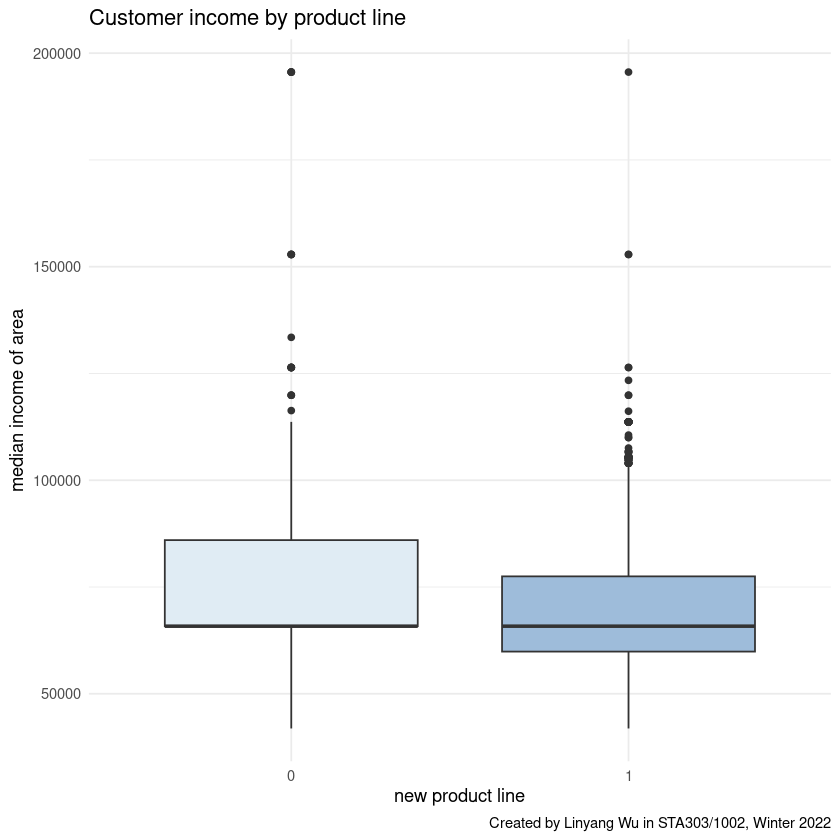

In [4]:
cust %>%
  ggplot(aes(x = as_factor(new_line), y = area_median_income, fill = as_factor(new_line))) + 
  geom_boxplot() +ylab("median income of area")+xlab("new product line")+
  theme_minimal() +
  theme(legend.position="none") +
  scale_fill_brewer(palette="BuPu") +
  labs(caption = "Created by Linyang Wu in STA303/1002, Winter 2022") + 
  ggtitle("Customer income by product line")

*Plot 1: Boxplot of consumer income by product line* This boxplot describes the income of the customers versus which product they purchased such that if it is 0 it is traditional product and 1 if it is the newer product. The customers of the traditional line had the higher median incomes with a slightly high variance as compared to the newer line customers.


In [5]:
# customer age by product line

age_table <- cust %>% group_by(new_line, sex) %>% mutate(new_line = case_when(new_line == 0 ~ "Traditional",
                                                                              new_line == 1 ~ "New")) %>% summarize(mean = mean(age), median = median(age), var = var(age), min = min(age), max = max(age), n = n())

knitr::kable(age_table, "pipe", col.names = c("Product Line", "Sex", "Mean", "Median", "Var.", "Min.", "Max.", "n"),
             caption = "Customer Age By Product Line", digits = 2)

`summarise()` has grouped output by 'new_line'. You can override using the
`.groups` argument.




Table: Customer Age By Product Line

|Product Line |Sex    |  Mean| Median|   Var.| Min.| Max.|    n|
|:------------|:------|-----:|------:|------:|----:|----:|----:|
|New          |Female | 47.03|     47| 332.52|   17|   92| 6110|
|New          |Male   | 47.52|     47| 344.84|   17|   92| 4326|
|Traditional  |Female | 45.78|     45| 218.13|   17|   92| 4971|
|Traditional  |Male   | 45.81|     45| 219.56|   17|   92| 3416|

*Table 2: Customer age by product line* This table describes the age of the customers for each of the product lines according to their sex. In general the mean age of the customers using the traditional line was 2 points lower the mean age of the newer line consumers. The newer line male consumers had the highest variance in terms of their age and the highest number of consumers were newer line female consumers.

### Methods for Question 1:

The first question of our data analysis is what are the differences in characteristics in the newer line customers as compared to the customers of the traditional line. In this case our variable of interest is a binary variable indicating whether the consumer bought the new line product or the traditional product. The predictor variables we were first interested in was the area median income according to the consumer postal code, the age of the consumer, the skin colour of the emoji modifier that the consumer chose, the biological sex of the consumer, the ID and the postal code. 

The method that we chose was generalized linear mixed models (GLMM) with logit link because we shouldn’t use LMMs because of the response variable which is binary in our case, and we shouldn’t use GLMs because of grouping/repeated measures in our data. Even though the IDs of each of the consumers were unique there could be repeated purchases from the same consumer making a different account etc. Also, GLMMs can be used in a range of situations where observations are grouped in some way (not all independent).

The fixed effects of the model were area median income, age, skin colour and sex since these are not random quantities. The income and the age variable were rescaled from 0-1 interval. The random effects of the model were ID and Postal code. Since these are individual level random effects as discussed above. After fitting different models and doing likelihood ratio tests in between nested models. We had no evidence against the claim that the model with the income, age and ID is as good a fit to the data as the model with the more complicated random effect/fixed effect structure.

$$Y_{i} \sim Bernoulli(p_{i})$$
$$Logit(p_{i}) = \mu + income_i*\beta_1 + age_i*\beta_2 + U_i$$
$$U_{i} \sim N(0, \sigma^2)$$


where:

- $Y_{i}$ is whether the customer bought the newer line Active/Advance product.
- $\mu$ is the intercept in the model.
- $income_i$ is the fixed effect of income.
- $age_i$ is the fixed effect of age.
- $U_{i}$ is the consumer ID random effect.
- $U_{i} > 0$ if i is more likely than the average to purchase the newer line product (allows for within-individual dependence).

The assumptions of GLMMs are:
1. Our customers are independent.
2. Random effects come from a normal distribution.
3. The random effects errors and within-unit residual errors have constant variance.
4. The chosen link function is appropriate.
After plotting the residual vs fitted model and plotting the qqplots we deemed that the assumptions of our model was met.

In [6]:
rescaled_age <- scales::rescale(cust$age)
rescaled_income <- scales::rescale(cust$area_median_income)
cust <- cust%>% mutate(rescaled_age)
cust <- cust%>% mutate(rescaled_income)

cust_fit <- lme4::glmer(new_line ~ rescaled_income + rescaled_age + skin_colour + sex + (1 | cust_id) + (1 | PC), 
        family=binomial(link='logit'), control=glmerControl(optimizer="bobyqa",  optCtrl=list(maxfun=2e5)), data=cust)

cust_fit1 <- lme4::glmer(new_line ~ rescaled_income + rescaled_age + skin_colour + sex + (1 | cust_id), 
        family=binomial(link='logit'), control=glmerControl(optimizer="bobyqa",  optCtrl=list(maxfun=2e5)), data=cust)

cust_fit2 <- lme4::glmer(new_line ~ rescaled_income + rescaled_age + sex + (1 | cust_id), 
        family=binomial(link='logit'), control=glmerControl(optimizer="bobyqa",  optCtrl=list(maxfun=2e5)), data=cust)

cust_fit3 <- lme4::glmer(new_line ~ rescaled_income + rescaled_age + (1 | cust_id), 
        family=binomial(link='logit'), control=glmerControl(optimizer="bobyqa",  optCtrl=list(maxfun=2e5)), data=cust)

cust_fit4 <- lme4::glmer(new_line ~ rescaled_income + (1 | cust_id), 
        family=binomial(link='logit'), control=glmerControl(optimizer="bobyqa",  optCtrl=list(maxfun=2e5)), data=cust)

cust_fit5 <- glm(new_line ~ rescaled_income + rescaled_age ,family=binomial(link='logit'), data=cust)

summary(cust_fit1)
summary(cust_fit2)
summary(cust_fit3)

lmtest::lrtest(cust_fit, cust_fit1)
lmtest::lrtest(cust_fit1, cust_fit2)
lmtest::lrtest(cust_fit2, cust_fit3)
lmtest::lrtest(cust_fit3, cust_fit4)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00299753 (tol = 0.002, component 1)”


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: new_line ~ rescaled_income + rescaled_age + skin_colour + sex +  
    (1 | cust_id)
   Data: cust
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 25447.1  25525.6 -12713.6  25427.1    18813 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5575 -1.1141  0.7243  0.8699  3.1605 

Random effects:
 Groups  Name        Variance Std.Dev.
 cust_id (Intercept) 0.000945 0.03074 
Number of obs: 18823, groups:  cust_id, 18823

Fixed effects:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)              0.63934    0.05246  12.187  < 2e-16 ***
rescaled_income         -3.08739    0.17103 -18.052  < 2e-16 ***
rescaled_age             0.37557    0.06623   5.671 1.42e-08 ***
skin_colourLight        -0.03147    0.04683  -0.672    0.502    
skin_colourMedium

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: new_line ~ rescaled_income + rescaled_age + sex + (1 | cust_id)
   Data: cust
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 25438.9  25478.2 -12714.5  25428.9    18818 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5550 -1.1155  0.7240  0.8697  3.1674 

Random effects:
 Groups  Name        Variance  Std.Dev.
 cust_id (Intercept) 0.0008335 0.02887 
Number of obs: 18823, groups:  cust_id, 18823

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.64454    0.04428  14.556  < 2e-16 ***
rescaled_income -3.11653    0.16052 -19.416  < 2e-16 ***
rescaled_age     0.37587    0.06622   5.676 1.38e-08 ***
sexMale          0.03735    0.03018   1.238    0.216    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correla

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: new_line ~ rescaled_income + rescaled_age + (1 | cust_id)
   Data: cust
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 25438.5  25469.8 -12715.2  25430.5    18819 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5379 -1.1155  0.7258  0.8695  3.1395 

Random effects:
 Groups  Name        Variance  Std.Dev.
 cust_id (Intercept) 0.0009396 0.03065 
Number of obs: 18823, groups:  cust_id, 18823

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.65911    0.04266  15.451  < 2e-16 ***
rescaled_income -3.11379    0.16004 -19.457  < 2e-16 ***
rescaled_age     0.37655    0.06621   5.687 1.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) rscld_n
rescald_ncm -

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11,-12713.57,NA,NA,NA
2,10,-12713.57,-1,5.20231e-09,0.9999425


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,-12713.57,NA,NA,NA
2,5,-12714.47,-5,1.789598,0.8774242


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,-12714.47,NA,NA,NA
2,4,-12715.24,-1,1.532274,0.2157715


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,-12715.24,NA,NA,NA
2,3,-12731.52,-1,32.56549,1.15243e-08


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: new_line ~ rescaled_income + rescaled_age + (1 | cust_id)
   Data: cust
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 25438.5  25469.8 -12715.2  25430.5    18819 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5379 -1.1155  0.7258  0.8695  3.1395 

Random effects:
 Groups  Name        Variance  Std.Dev.
 cust_id (Intercept) 0.0009396 0.03065 
Number of obs: 18823, groups:  cust_id, 18823

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.65911    0.04266  15.451  < 2e-16 ***
rescaled_income -3.11379    0.16004 -19.457  < 2e-16 ***
rescaled_age     0.37655    0.06621   5.687 1.29e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) rscld_n
rescald_ncm -

 Groups  Name        Std.Dev.
 cust_id (Intercept) 0.030653

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.66,0.04,15.45,0
rescaled_income,-3.11,0.16,-19.46,0
rescaled_age,0.38,0.07,5.69,0


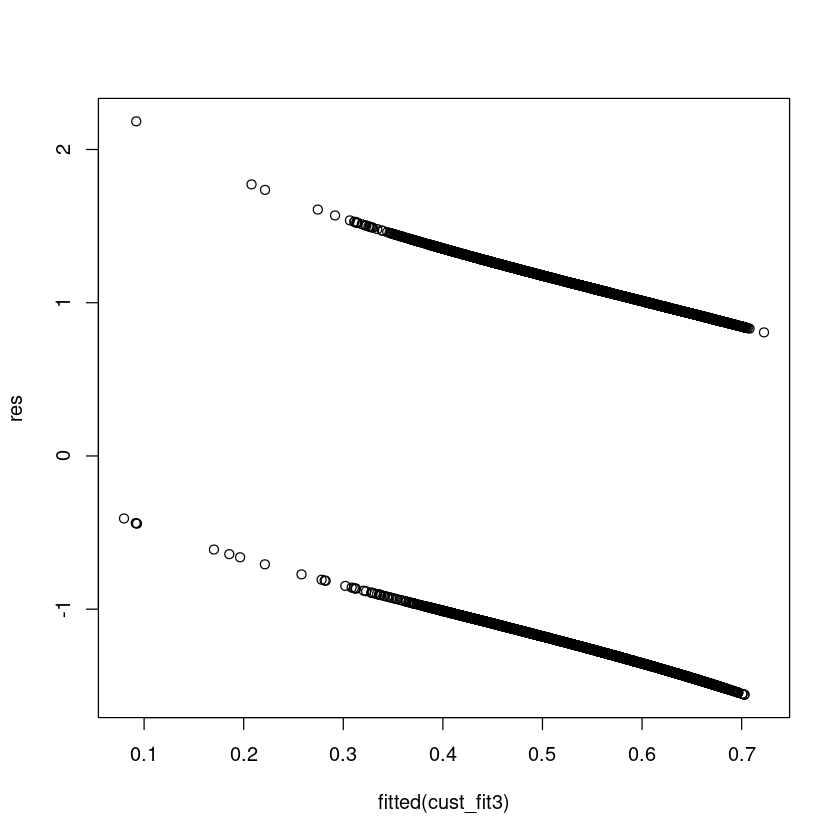

In [7]:
res <- resid(cust_fit3)
plot(fitted(cust_fit3), res)



summary(cust_fit3)

lme4::VarCorr(cust_fit3)

round(summary(cust_fit3)$coef, digits=2)

# knitr::kable(round(summary(cust_fit)$coef, digits=2), caption = "Fixed effects")


confint = confint.merMod(cust_fit3, method = "Wald")

# lattice::dotplot(lme4::ranef(cust_fit3, condVar=TRUE)) 

ests <- format(round(exp(summary(cust_fit3)$coeff)[,1], 2), nsmall = 2)

cis <- format(round(exp(confint),2)[-1,], nsmall = 2)

cis_pretty <- str_c("(", trimws(cis[,1]), ", ", cis[,2], ")")

rownames_for_table <- c("Baseline odds of purchasing newer line", "Income of area", "Age")
colnames_for_table <- c("Estimate", "95% CI")

my_pretty_table <- cbind(ests, cis_pretty)
rownames(my_pretty_table) <- rownames_for_table
colnames(my_pretty_table) <- colnames_for_table

### The results

In [10]:
knitr::kable(my_pretty_table, align = c("r", "r"), caption = "Confidence Intervals And Estimates")



Table: Confidence Intervals And Estimates

|                                       | Estimate|       95% CI|
|:--------------------------------------|--------:|------------:|
|Baseline odds of purchasing newer line |     1.93| (1.78, 2.10)|
|Income of area                         |     0.04| (0.03, 0.06)|
|Age                                    |     1.46| (1.28, 1.66)|

The age variable were rescaled to 0 to 1 which 0 is the youngest of 18 and the oldest 1 being 92. Also the income variable was rescaled 0 to 1 with the minimum being `r min(cust$area_median_income)` and the maximum being `r max(cust$area_median_income)`. The odds ratio of the customer buying the newer product, going from the youngest age to the oldest age (92), holding income constant, is an estimate of `r 1.46^2`. Hence, we estimate that the odds of the consumer purchasing the newer product when the age goes from youngest to oldest is over 2 times higher. In other words a customer is likely to purchase the newer product are 2.1316 times higher when the customer is age 92 compared to a customer aged 18. The exponentiated point estimate is 0.95 with a confidence interval of (1.28, 1.66) for $beta_2$. There was no significant change in odds of a consumer purchasing the newer product when their area income goes from minimum to maximum. 


## Question 1: Do people with darker skin experience more issues with sleep tracking in their device than people with lighter skin?

### Data exploration for Question 2:

In [11]:
# second research question

# EDA

sleep <- readRDS("~/sta303-w22-final-project-template/data/sleep.rds")


sleep$skin_colour <- factor(sleep$skin_colour, levels = c("Light", "Medium Light", "Medium", "Medium Dark", "Dark"))

`summarise()` has grouped output by 'new_line'. You can override using the
`.groups` argument.


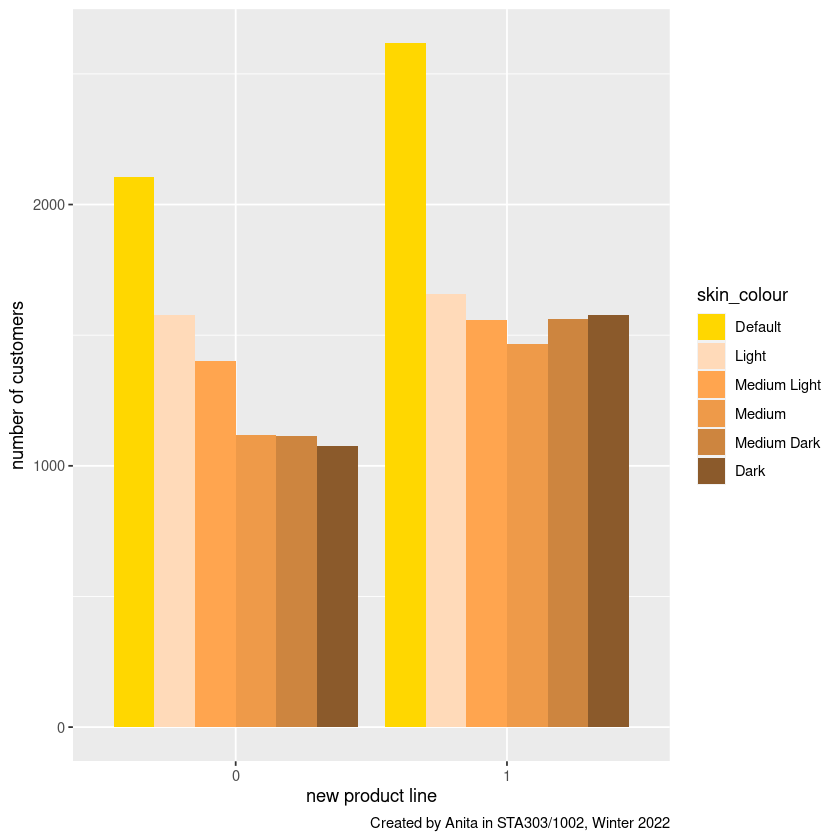

In [13]:
# Product Line by skin_colour
cust %>% group_by(new_line, skin_colour) %>% summarise(n = n())%>%
  ggplot(aes(x=factor(new_line), y=n, fill=skin_colour)) + 
  geom_bar(stat="identity", position=position_dodge()) +scale_fill_manual(values=c("Default"="gold", "Light"="peachpuff1", "Medium Light"="tan1", "Medium"="tan2", "Medium Dark"="tan3","Dark"="tan4" ))+xlab("new product line") + ylab("number of customers") +
  labs(caption = "Created by Anita in STA303/1002, Winter 2022")

*Product sold by skin colour* The barplot shows the number of people buying each product, grouped by skin colour, to get an idea of the diversity of your customers. For the newer product line the numbers of customers using the default skin tone emoji was significantly higher than the customers other types of customers who chose their emoji skin tone.


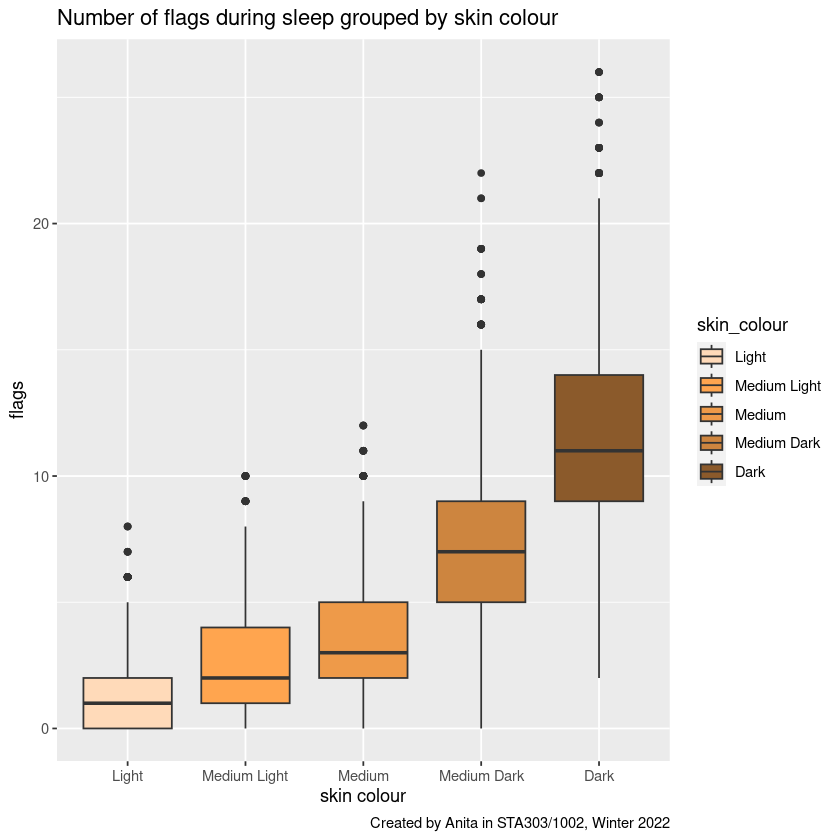

In [16]:
sleep %>% group_by(skin_colour) %>%
  ggplot(aes(x=factor(skin_colour), y=flags, fill=skin_colour)) + 
  geom_boxplot()+ggtitle("Number of flags during sleep grouped by skin colour")+xlab("skin colour")+scale_fill_manual(values=c("Light"="peachpuff1", "Medium Light"="tan1", "Medium"="tan2", "Medium Dark"="tan3","Dark"="tan4" )) + labs(caption = "Created by Anita in STA303/1002, Winter 2022")

*Sleep flags by skin colour* The bar plot shows the number of flags during a customers sleep session according to their skin colour. The darker the skin tone emoji used by the customer the more issues with sleep tracking in their device compares to people with lighter skin or people who are using the default skin tone emoji.

In [18]:
flag_table <- sleep%>%
  group_by(skin_colour) %>% summarise(mean = mean(flags), var = var(flags), n = n())

knitr::kable(flag_table, "pipe", col.names = c("Skin Tone", "MeanFlags", "Variance of Flags", "number of flags"),
             digits = 2)



|Skin Tone    | MeanFlags| Variance of Flags| number of flags|
|:------------|---------:|-----------------:|---------------:|
|Light        |      1.16|              1.68|            3680|
|Medium Light |      2.50|              3.60|            3173|
|Medium       |      3.65|              4.98|            2962|
|Medium Dark  |      7.43|             10.16|            2862|
|Dark         |     11.79|             16.09|            2687|

*Mean and Variance of Flags During Sleep By Skin Tone* The mean number and the variance in the number of flags for dark skin tone emoji users was higher than that of light skin tone emoji users.

### Methods for Question 2:
The second question we were interested in was whether people with darker skin experience more issues with sleep tracking in their device than people with lighter skin. The dataset was provided by MINGAR and contained customer information such as age, sex, income, device, and emoji modifier. The variable of interest was the number of flags per hour of sleep, where a flag represents an issue in tracking sleep quality. The predictor variables were skin colour, age, sex, and device. We used the emoji modifier to sort the customers based on their skin colour, under the assumption that people choose the colour of their emoji to match their own skin colour. We removed customers that used the default emoji, as it is difficult to make assumptions about the skin colour of people using this emoji. Observations that did not have information about their sex were also removed. After these changes, the number of unique customers from 974 to 710. This is an observational study, since we do not have control over any of the variables.

#### Model

The distribution of the number of flags seemed to follow a Poisson distribution, so we fit several general linear mixed Poisson models in version 4.0.5 of R (R Core Team, 2021) using the lme4 package (Bates, Maechker, Bolker, & Walker, 2015). The following model is the final model: 

$$Y_i \sim Poisson(\lambda_i)$$
$$ Log(\lambda_i)=x_i*\beta + U_i $$

where:
-$Y_i$ is the number of flags per hour of sleep
-$\lambda$ is the mean number of flags for each skin colour group
-$x_1$ is the fixed effect of skin colour 
-$x_2$ is the fixed effect of age
-$U_i \sim N(0,\sigma^2)$ is customer id random effect 

The fixed effects of this model are skin colour and age, since we want to see how these variables affect the number of flags. The random effect is the customer id, since we expect different customers to have random variation in the number of flags and we want to be able to generalize to the whole population. We can use customer id as a random effect because there are several sleep sessions per customer, so it is treated as a grouping variable.
We arrived at this result after doing likelihood ratio tests to compare models. This process led us to conclude that sex and the device type have no significant effect on the number of flags.

`summarise()` has grouped output by 'skin_colour'. You can override using the
`.groups` argument.


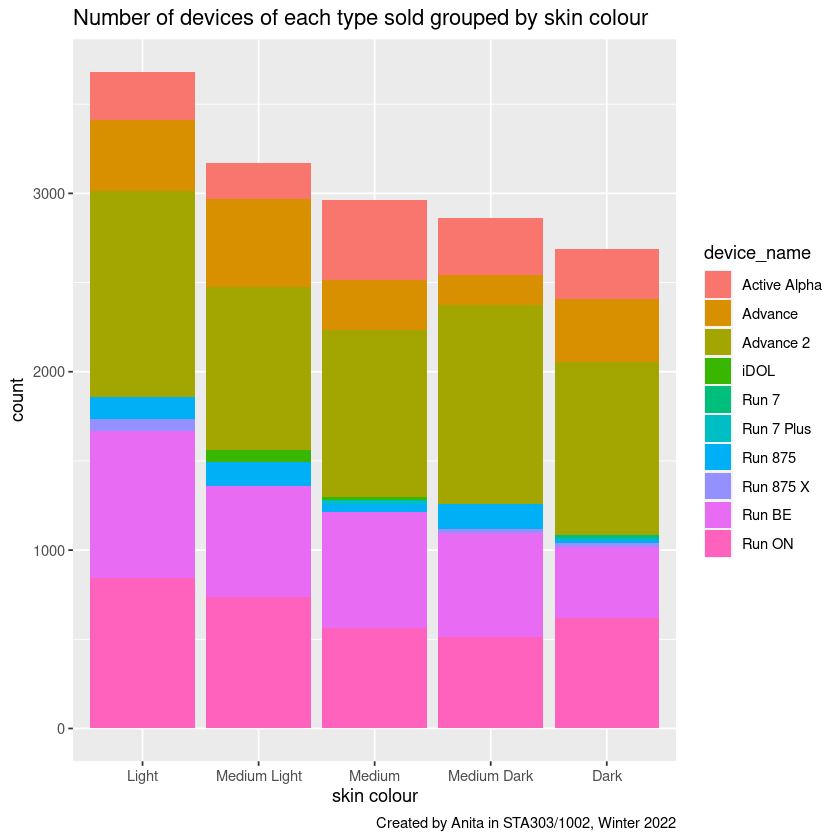

In [20]:
sleep %>%group_by(skin_colour, device_name)%>% summarize(n = n())%>%
  ggplot(aes(x=factor(skin_colour), y=n, fill = device_name)) + 
  geom_bar(stat="identity")+xlab("skin colour")+ylab("count")+ggtitle("Number of devices of each type sold grouped by skin colour") + labs(caption = "Created by Anita in STA303/1002, Winter 2022")

In [22]:
sleep <- sleep %>%
  drop_na(skin_colour)%>% drop_na(sex)


# after removing observations where skin_colour has NA's, the number of unique customers went from 974 to 719

length(unique(sleep$cust_id))

sleep_mod <- lme4::glmer(flags ~ skin_colour + scales::rescale(age) + sex + (1 | cust_id) + (1 | device_name), offset = log(duration), family='poisson', data=sleep)

sleep_mod1 <- lme4::glmer(flags ~ skin_colour + scales::rescale(age) + sex+ (1 | cust_id), offset = log(duration), family='poisson', data=sleep)

sleep_mod2 <- lme4::glmer(flags ~ skin_colour + scales::rescale(age) + (1 | cust_id), offset = log(duration), family='poisson', data=sleep)



summary(sleep_mod)
summary(sleep_mod1)
summary(sleep_mod2)

lmtest::lrtest(sleep_mod, sleep_mod1)
lmtest::lrtest(sleep_mod1, sleep_mod2)

[1] 719

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: flags ~ skin_colour + scales::rescale(age) + sex + (1 | cust_id) +  
    (1 | device_name)
   Data: sleep
 Offset: log(duration)

     AIC      BIC   logLik deviance df.resid 
 64982.7  65059.0 -32481.3  64962.7    15233 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9606 -0.9406 -0.1267  0.7310  6.1981 

Random effects:
 Groups      Name        Variance  Std.Dev. 
 cust_id     (Intercept) 2.108e-03 4.592e-02
 device_name (Intercept) 5.515e-09 7.426e-05
Number of obs: 15243, groups:  cust_id, 719; device_name, 10

Fixed effects:
                          Estimate Std. Error  z value Pr(>|z|)    
(Intercept)             -5.7717013  0.0175051 -329.715  < 2e-16 ***
skin_colourMedium Light  0.7762487  0.0197815   39.241  < 2e-16 ***
skin_colourMedium        1.1777951  0.0189242   62.237  < 2e-16 ***
skin_colourMedium Dark   1.8909279  0.0176956 

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: flags ~ skin_colour + scales::rescale(age) + sex + (1 | cust_id)
   Data: sleep
 Offset: log(duration)

     AIC      BIC   logLik deviance df.resid 
 64980.7  65049.3 -32481.3  64962.7    15234 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9606 -0.9406 -0.1267  0.7310  6.1981 

Random effects:
 Groups  Name        Variance Std.Dev.
 cust_id (Intercept) 0.002108 0.04592 
Number of obs: 15243, groups:  cust_id, 719

Fixed effects:
                          Estimate Std. Error  z value Pr(>|z|)    
(Intercept)             -5.7717087  0.0175052 -329.715  < 2e-16 ***
skin_colourMedium Light  0.7762551  0.0197815   39.241  < 2e-16 ***
skin_colourMedium        1.1778038  0.0189243   62.238  < 2e-16 ***
skin_colourMedium Dark   1.8909351  0.0176956  106.859  < 2e-16 ***
skin_colourDark          2.3899497  0.0172847  138.270  < 2e-16 ***
scales::re

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: flags ~ skin_colour + scales::rescale(age) + (1 | cust_id)
   Data: sleep
 Offset: log(duration)

     AIC      BIC   logLik deviance df.resid 
 64978.6  65032.0 -32482.3  64964.6    15236 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9588 -0.9410 -0.1268  0.7301  6.1984 

Random effects:
 Groups  Name        Variance Std.Dev.
 cust_id (Intercept) 0.002137 0.04623 
Number of obs: 15243, groups:  cust_id, 719

Fixed effects:
                        Estimate Std. Error  z value Pr(>|z|)    
(Intercept)             -5.77260    0.01724 -334.893  < 2e-16 ***
skin_colourMedium Light  0.77650    0.01979   39.237  < 2e-16 ***
skin_colourMedium        1.17812    0.01893   62.227  < 2e-16 ***
skin_colourMedium Dark   1.89072    0.01770  106.797  < 2e-16 ***
skin_colourDark          2.39002    0.01730  138.184  < 2e-16 ***
scales::rescale(age)    -0.0

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,-32481.33,NA,NA,NA
2,9,-32481.33,-1,2.416332e-05,0.9960779


,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9,-32481.33,NA,NA,NA
2,7,-32482.31,-2,1.9659,0.3742055


In [24]:
confint = confint.merMod(sleep_mod2, method = "Wald")


ests <- format(round(exp(summary(sleep_mod2)$coeff)[,1], 2), nsmall = 2)

cis <- format(round(exp(confint),2)[-1,], nsmall = 2)

cis_pretty <- str_c("(", trimws(cis[,1]), ", ", cis[,2], ")")

rownames_for_table <- c("Intercept", "Medium LIght", "Medium", "medium Dark", "Dark", "age")
colnames_for_table <- c("Estimate", "95% CI")

my_pretty_table <- cbind(ests, cis_pretty)
rownames(my_pretty_table) <- rownames_for_table
colnames(my_pretty_table) <- colnames_for_table

In [26]:
knitr::kable(my_pretty_table, align = c("r", "r"))



|             | Estimate|         95% CI|
|:------------|--------:|--------------:|
|Intercept    |     0.00|  (0.00,  0.00)|
|Medium LIght |     2.17|  (2.09,  2.26)|
|Medium       |     3.25|  (3.13,  3.37)|
|medium Dark  |     6.62|  (6.40,  6.86)|
|Dark         |    10.91| (10.55, 11.29)|
|age          |     0.95|  (0.92,  0.99)|

#### Results

  We found that light-skinned people are the most common type of customer for MINGAR. The three most popular products are the Run ON, Run BE, and Advance 2; they are the most popular among all customers, regardless of skin colour. The duration of sleep does not differ much by skin colour, although there is a slight pattern showing that the darker the skin the lower the amount of sleep. However, darker-skinned people had much more flags per hour during their sleep, with an average of 11.8 flags per hour, compared to 1.2 for light-skinned individuals. As well, the variance in number of flags is quite high for dark-skinned individuals, with a variance of 16.09. The variance for light-skinned people is only 1.68. This can be seen in Figure 2 below.

  After fitting several models, we find that the variables that have a significant effect on the number of flags are skin colour and age, with customer id as a random variable. Older individuals on average have more accuracy in their sleep tracking. Since the variable was rescaled, the minimum value is 0 and the maximum is 1. Thus, going from the youngest age (18) to the oldest age (92), holding skin colour constant, decreases the number of flags by five percent. The exponentiated estimates and 95 percent confidence intervals can be seen in Table 2 below. For skin colour, they estimate the factor by which the number of flags changes given a change from being light-skinned to the given skin colour, keeping age constant. For age,  they estimate the factor by which the number of flags changes given a one unit increase in age, holding skin colour constant. The exponentiated point estimate is 0.95 with a confidence interval of (     ). Skin colour also has a significant effect on the number of flags. Relative to being light-skinned, darkening the skin colour increases the number of flags. For example, having medium-light skin means one is 2.2 times more likely to get flagged than a light-skinned person, with a confidence interval of (2.09, 2.26). This means we are 95 percent confident that the true value is in this interval. The factors increase as skin tone darkens; an individual with the darkest skin tone is 10.9 times more likely than a light-skinned individual to get flagged. However, the confidence interval is wider: (10.55, 11.29), reflecting the fact that there is higher variation in the number of flags. It is clear though that there is a significant increase in the number of flags for all darker skin tones. The type of device as well as the level of income is not significant in the model, indicating that the number of flags is not affected by the type of device or the level of income of the individual.

## Discussion

The goal of our first research question was to determine the if there were any differences between the customers who bought the newer and affordable product as opposed to the customers who bought the traditional product. We found that there is some significant evidence that when a customer is aged 92 the odds of that customer buying the new product is 2.1316 times more likely as opposed to a customer who is aged 18. This is with a 95% confidence interval of (1.28, 1.66). However, there was no significant change of the odds of a customer buying the new product if their average income of the area according to their postal code is \$ 195570 as compared to a customer with \$ 41880 income. The limitation of this particular research question is that the data only consists of the postal code of the customer. We have no real data of their household income. There may be many cases where the average income of the household of a particular precinct differs significantly from their real income. 

Regarding the second research question, there is significant evidence that individuals with darker skin tones experience more sleep quality flags per hour of sleep than lighter skinned individuals. There is a 95 percent likelihood that individuals with the darkest skin tone are between 10.5 to 11.3 times more likely to get flagged during their sleep than light-skinned individuals. There is also greater variation in the number of flags for darker-skinned people. The type of device is not significant in this result, indicating that this issue persists among all devices.

### Strengths and limitations

There are several limitations of this study. First, the most popular emoji modifier is the default one, so there is a large portion of the sample that is not able to be investigated when comparing people of different skin tones. While the assumption that individuals pick the emoji colour to match their skin tone is reasonable, there may be some people who make it different for fun, or to fit in with the majority, which may create biased results. We do not have the actual data of the customer's skin colour and the emoji colour may not match a customer's real skin tone. Also, there may be other variables that affect the quality of sleep that are not included, such as noisiness of the neighbourhood, a presence of sleep disorders, stress level, general health, or sleep time. Furthermore, for the technical resources we used the Wald method to calculate our confidence intervals. Even though Wald method is known to be fast and efficient it may not be as precise as the profile likelihood and this due to computational resources. Lastly, we used the variable biological sex instead of pronouns for interpretation. There may have been useful founding in which pronouns could have affected the odds of a customer buying the newer product and their sleep quality flags.

# References

1. R Core Team (2021). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.r-project.org/.

2. Wickham et al., (2019). Welcome to the tidyverse. Journal of Open Source Software, 4(43), 1686, https://doi.org/10.21105/joss.01686

3. Douglas Bates, Martin Maechler, Ben Bolker, Steve Walker (2015). Fitting Linear Mixed-Effects Models Using lme4. Journal of Statistical Software, 67(1), 1-48. doi:10.18637/jss.v067.i01.

4. Hadley Wickham (2021). rvest: Easily Harvest (Scrape) Web Pages. https://rvest.tidyverse.org/, https://github.com/tidyverse/rvest.

5. Achim Zeileis, Torsten Hothorn (2002). Diagnostic Checking in Regression Relationships. R News 2(3), 7-10. URL https://cran.r-project.org/doc/Rnews/

6. Dmytro Perepolkin (2019). polite: Be Nice on the Web. R package version 0.1.1. https://github.com/dmi3kno/polite

7. Emoji Charts. https://unicode.org/emoji/charts/full-emoji-modifiers.html#1f44a_1f3fc

8. Statistical Society of Canada. Code of Ethical Statistical Practice. https://ssc.ca/sites/default/files/data/Members/public/Accreditation/ethics_e.pdf

\newpage
# Appendix

## Web scraping industry data on fitness tracker devices

To web scrape the fitness tracker website we used the bow and scrape function to then make the list into a table. Most importantly the user agent profile including the email and the project it was used for was provided.

## Accessing Census data on median household income

While accessing the income data on the canadian census API we entered the censusmapper.ca website to get the API key and set up a folder for cache. The API key is a private information about my account and was not included in the project. After getting the household median income the data was simplified to only the needed variables for our project.

## Accessing postcode conversion files

To access the postcode conversion files we accepted the license agreement. This was a private and protected data that should not go on GitHub of any other public repositories. Only the data needed for our final submission of the project was saved.
